In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from allen_v1dd.client import EMClient
from allen_v1dd.em import DynamicSynapseGraph
from allen_v1dd.stimulus_analysis import analysis_tools as at
from allen_v1dd.stimulus_analysis.analysis_tools import iter_plane_groups

at.set_stylesheet()
at.set_analysis_file("/Users/chase/Desktop/stimulus_analyses_v1.h5")
at.set_included_mice([409828])
at.set_included_columns([1])
at.set_included_volumes([3])

%load_ext autoreload
%autoreload 2

In [2]:
em_client = EMClient()

In [7]:
syn_graph = DynamicSynapseGraph(em_client, debug=True, filename=f"/Users/chase/Desktop/v1dd_v{em_client.version}_synapses.gpl")

Loading graph from file /Users/chase/Desktop/v1dd_v349_synapses.gpl


In [3]:
coreg_df = em_client.get_coregistration_table()
coreg_df = coreg_df[coreg_df.axon_proof_complete]
len(coreg_df)

HTTPError: 500 Server Error: INTERNAL SERVER ERROR for url: https://api.em.brain.allentech.org/materialize/api/v3/datastack/v1dd/version/352/query?return_pyarrow=True&split_positions=True content:b'{"message": "Internal Server Error"}\n'

In [167]:
pt_root_ids = coreg_df.pt_root_id.values
all_syn = syn_graph.get_axonal_synapses(pt_root_ids)
all_syn

,pre_pt_root_id,post_pt_root_id,size,soma_soma_dist,soma_soma_dist_horiz,syn_pre_soma_dist_straight,syn_post_soma_dist_straight
0,864691132827688641,864691132793765103,1695,265.448929,157.434837,284.286695,26.457866
1,864691132827688641,864691132793765103,2235,265.448929,157.434837,278.138891,62.310554
2,864691132827688641,864691132808618273,1226,44.579349,24.630921,58.370658,58.253547
3,864691132827688641,864691132808618273,2075,44.579349,24.630921,33.236201,39.054908
4,864691132827688641,864691132808618273,1713,44.579349,24.630921,76.673633,62.053093
...,...,...,...,...,...,...,...
34963,864691132736082347,864691132064499669,2218,NaN,NaN,41.362939,NaN
34964,864691132736082347,864691132758689131,535,164.831034,150.166135,86.715330,79.379862
34965,864691132736082347,864691132742345052,783,130.149474,109.751023,88.130729,48.531435
34966,864691132736082347,864691132656476120,684,102.023656,100.504906,67.201556,72.799797


(array([2.2153e+04, 7.9500e+03, 3.0380e+03, 1.1260e+03, 4.3500e+02,
        1.7100e+02, 5.8000e+01, 2.4000e+01, 1.1000e+01, 2.0000e+00]),
 array([  100. ,  1580.4,  3060.8,  4541.2,  6021.6,  7502. ,  8982.4,
        10462.8, 11943.2, 13423.6, 14904. ]),
 <BarContainer object of 10 artists>)

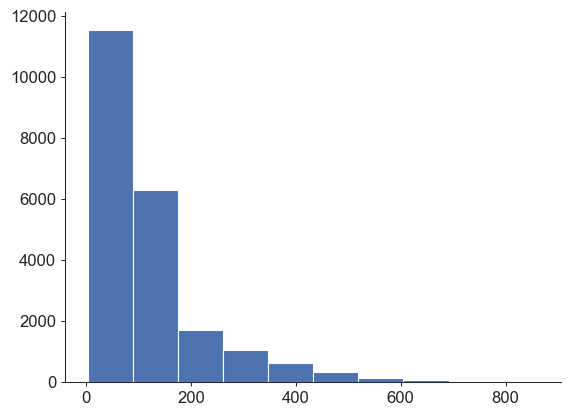

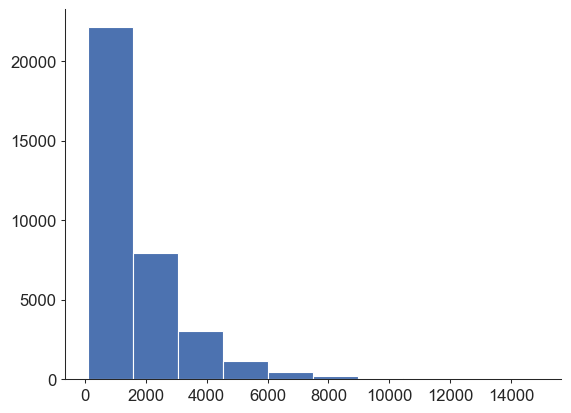

In [168]:
plt.hist(all_syn["syn_post_soma_dist_straight"])
plt.figure()
plt.hist(all_syn["size"])

In [169]:
# Load the functional metrics
metrics = []
for group in iter_plane_groups():
    roi_prefix = f"{group.attrs['session_id']}_{group.attrs['plane']}"
    dg = group["drifting_gratings_full"]
    rois = np.where(group["is_roi_valid"][()] & (dg["frac_responsive_trials"][()] > 0.25))[0]

    for roi in rois:
        metrics.append(dict(
            roi = f"{roi_prefix}_{roi}",
            osi = dg["gosi"][roi],
            dsi = dg["dsi"][roi],
            pref_dir = dg["pref_cond"][roi, 0],
            pref_sf = dg["pref_cond"][roi, 1],
        ))

metrics = pd.DataFrame(metrics)
metrics.set_index("roi", inplace=True)
metrics

,osi,dsi,pref_dir,pref_sf
roi,,,,
M409828_13_0_0,0.133519,0.498349,0.0,0.04
M409828_13_0_6,0.751979,0.952003,330.0,0.08
M409828_13_0_10,0.355247,1.000000,330.0,0.04
M409828_13_0_11,0.109165,1.000000,330.0,0.04
M409828_13_0_14,0.577535,0.847013,120.0,0.04
...,...,...,...,...
M409828_13_5_635,0.137921,0.414378,270.0,0.08
M409828_13_5_640,0.151139,0.321881,120.0,0.04
M409828_13_5_645,0.080046,0.643351,90.0,0.08


In [170]:
coreg_df.roi.isin(metrics.index).sum()

33

In [171]:
roi_synapses = [] # (presyn_roi, postsyn_roi, syn_attrs) where ROI is e.g. M409828_13_0_6
root_id_to_roi = pd.Series(index=coreg_df.pt_root_id.values, data=coreg_df.roi.values)

for row in coreg_df.itertuples():
    pre_root_id = row.pt_root_id
    pre_roi = row.roi
    for syn_attrs in syn_graph.get_axonal_synapses(pre_root_id).to_dict(orient="records"):
        post_root_id = syn_attrs["post_pt_root_id"]
        if post_root_id in root_id_to_roi:
            roi_synapses.append((pre_roi, root_id_to_roi[post_root_id], syn_attrs))

len(roi_synapses), roi_synapses[0]

(99,
 ('M409828_13_0_75',
  'M409828_13_2_294',
  {'pre_pt_root_id': 864691132728579766,
   'post_pt_root_id': 864691132598451263,
   'size': 2181,
   'soma_soma_dist': 69.35651361624237,
   'soma_soma_dist_horiz': 63.81876621280135,
   'syn_pre_soma_dist_straight': 90.94521501959301,
   'syn_post_soma_dist_straight': 46.79303616415586}))

Text(0, 0.5, 'Number of synapses')

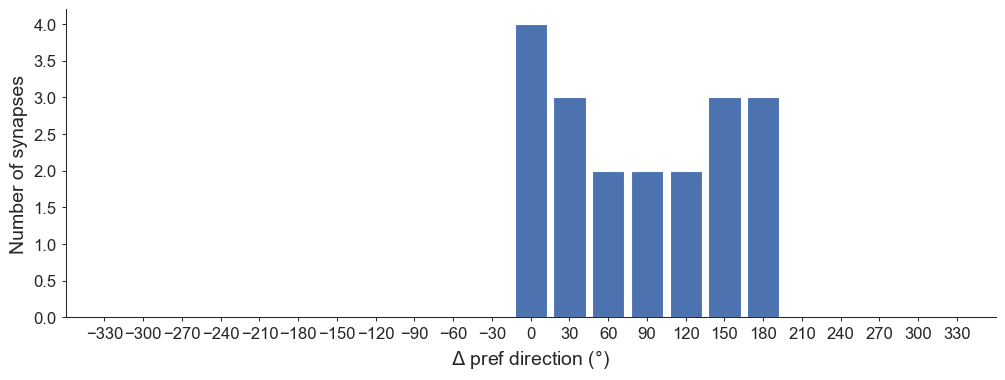

In [181]:
delta_ori_to_n_syn = {}

# M = metrics[(metrics.dsi > 0.2)]
M = metrics

for pre_roi, post_roi, syn_attrs in roi_synapses:
    if pre_roi in M.index and post_roi in M.index:
        delta_ori = M.loc[post_roi, "pref_dir"] - M.loc[pre_roi, "pref_dir"]
        delta_ori = abs(M.loc[post_roi, "pref_dir"] - M.loc[pre_roi, "pref_dir"])
        delta_ori = min(delta_ori, 360-delta_ori)
        # delta_ori_to_n_syn[delta_ori] = delta_ori_to_n_syn.get(delta_ori, 0) + 1
        # delta_ori_to_n_syn[delta_ori] = delta_ori_to_n_syn.get(delta_ori, 0) + syn_attrs["size"]
        # delta_ori_to_n_syn[delta_ori] = delta_ori_to_n_syn.get(delta_ori, 0) + syn_attrs["syn_post_soma_dist_straight"]
        # if syn_attrs["syn_post_soma_dist_straight"] > 75:
            # delta_ori_to_n_syn[delta_ori] = delta_ori_to_n_syn.get(delta_ori, 0) + 1
        if syn_attrs["soma_soma_dist"] < 100:
            delta_ori_to_n_syn[delta_ori] = delta_ori_to_n_syn.get(delta_ori, 0) + 1

plt.figure(figsize=(12, 4))
plt.bar(x=list(delta_ori_to_n_syn.keys()), height=list(delta_ori_to_n_syn.values()), width=25)
# plt.xticks(np.arange(0, 360, 30))
plt.xticks(np.arange(-330, 360, 30))
plt.xlim(-360, 360)
plt.xlabel("$\Delta$ pref direction (°)")
plt.ylabel("Number of synapses")

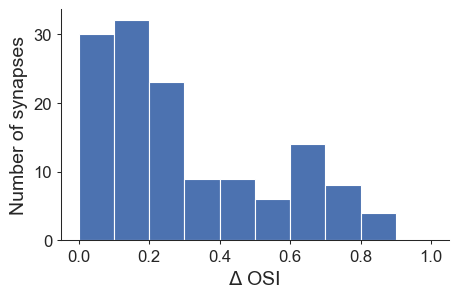

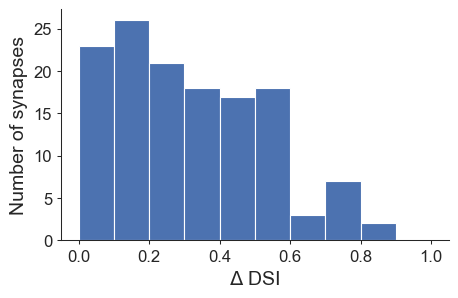

In [51]:
for met in ("osi", "dsi"):
    delta_met = []

    for pre_roi, post_roi, syn_attrs in roi_synapses:
        if pre_roi in metrics.index and post_roi in metrics.index:
            delta_met.append(abs(metrics.loc[post_roi, met] - metrics.loc[pre_roi, met]))

    plt.figure(figsize=(5, 3))
    plt.hist(delta_met, bins=np.arange(0, 1.1, 0.1))
    plt.xlabel(f"$\Delta$ {met.upper()}")
    plt.ylabel("Number of synapses")

    # TODO Need to test significance of these by comparing to randomly selected cells